# <font color='red'>Análise de Sentimentos em Tweets sobre o ChatGPT com PySpark</font>
# <font color='red'>Análise de Dados com Spark</font>
## <font color='red'>Gleidson Gomes - 25/06/2023</font>

## <font color='red'>1 - Introdução</font>

Este trabalho apresenta uma análise de sentimento a respeito do ChatGPT por meio de processamento de linguagem de dados textuais extraídas do Twitter.

A análise de sentimento consiste em identificar o sentimento de alguém por qualquer coisa por meio de um texto em linguagem natural [1].

O ChatGPT [2] é um serviço de Inteligência Artificial (IA) [3] que permite responder perguntas em geral em forma de texto a fim de esclarecer uma dúvida ou resolver um problema real.

O Twitter [4] é uma rede social que permite aos usuários enviar e receber atualizações pessoais de outros contatos (em textos de até 280 caracteres conhecidos como "tweets") por meio do "Website" do serviço, aplicativo e por programas específicos de gerenciamento.

O objetivo deste trabalho é identificar o sentimento das pessoas que predomina sobre o ChatGPT com o auxílio de processamento de linguagem de dados textuais extraídas de mensagens do Twitter com as seguintes condições:

#### Etapas:

* Entrada: mensagem de texto oriunda do Twitter para a análise de sentimento sobre o ChatGPT por meio da biblioteca TextBlob [5] para processamento de dados textuais suportada somente para a língua inglesa.

* Saída: classificação do sentimento da mensagem em neutro, positiva ou negativa.

#### Regras:

* mensagens que contém a palavra ChatGPT em seu texto no idioma inglês de qualquer localização geográfica;
 
* extração de 100 mensagens para análise inicial. Posteriormente automatizar a aplicação para extrair 1.500 mensagens por mês conforme limite permitido pelo serviço gratuito disponibilizado pela Twitter;
 
* aplicação de técnicas de pré-processamento de dados para melhorar o texto para análise, como a "Stop Word Removal" (remove palavras muito frequentes, tais como a, de, o, da, que, e, do, entre outras) e a "Text Lemmatization" (reduz as palavras flexionadas adequadamente para sua forma (lema) raiz considerando o contexto da palavra, bem como a palavra anterior [7].

Informações adicionais a título de trabalhos relacionados podem ser consultados em [6].

## <font color='red'>2 - Objetivo</font>

* Identificar o sentimento das pessoas que predomina sobre o ChatGPT por meio de processamento de linguagem de dados textuais extraídas de mensagens do Twitter e classificar em neutro, positivo e negativo.

## <font color='red'>3 - Preparação do ambiente PySpark</font>

In [37]:
# Instalação de pacotes
# Watermark é usado para gravar as versões de outros pacotes usados neste jupyter notebook
#!pip install -q -U watermark
 
# https://pypi.org/project/findspark/
#!pip install -q findspark

# Instalação da versão mais recente da biblioteca python de acesso a API do Twitter
#!pip install tweepy==4.5.0

# Instalação da biblioteca Python voltada para o processamento de dados textuais
#!pip install textblob

# Instalação da biblioteca para processamento de linguagem natural (PLN)
#!pip install nltk

In [1]:
# Importação das bibliotecas
from pyspark.sql import SparkSession
import tweepy                                     # biblioteca python para acessar a API do Twitter
from credenciais_api_twitter import *             # arquivo com as credenciais de acesso a API da Twitter
#----------------------------------------------------------------------------------------------------------------
from pyspark.sql.functions import udf             # bibioteca para escrita UDF (funções definidas pelo usuário) em python
from pyspark.sql.types import StringType          # biblioteca para converte objeto SQL interno em objeto Python nativo
from textblob import TextBlob                     # biblioteca Python voltada para o processamento de dados textuais
import re                                         # biblioteca para limpeza de caracteres especiais
#----------------------------------------------------------------------------------------------------------------
import nltk                                       # biblioteca para processamento de linguagem natural (PLN)
nltk.download('stopwords')                        # módulo para atualização da lista de stop words
stop = nltk.corpus.stopwords.words('english')     # variável com a lista de stop words
nltk.download('wordnet')                          # módulo para realizar lematização em palavras
w_tokenizer = nltk.tokenize.WhitespaceTokenizer() # variável para o processo de "tokenização" para Lematização
lemmatizer = nltk.stem.WordNetLemmatizer()        # variável para o processo de Lematização
#----------------------------------------------------------------------------------------------------------------
import pandas as pd                               # pandas para manipulação de dados e análise exploratória dos dados
import seaborn as sns                             # biblioteca de visualização de dados em Python baseada em Matplotlib
from matplotlib import pyplot as plt              # matplotlib para criação de gráficos e visualizações de dados em geral
# para plotar os gráficos estáticos logo abaixo da célula
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gleid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gleid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Versões dos pacotes e linguagens utilizados neste projeto
%reload_ext watermark
%watermark -a "Análise de Sentimentos em Tweets sobre o ChatGPT com PySpark" --iversions

# Versão da Linguagem python
from platform import python_version
print('python    :', python_version())

Author: Análise de Sentimentos em Tweets sobre o ChatGPT com PySpark

nltk      : 3.6.5
seaborn   : 0.11.2
pandas    : 1.3.4
tweepy    : 4.5.0
re        : 2.2.1
matplotlib: 3.4.3

python    : 3.9.7


In [3]:
# Parâmetros de configuração dos gráficos
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

In [4]:
# Formatação das saídas dos dataframes do spark
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')   # exibe somente mensagem de erro

In [5]:
# Importa o findspark e inicializa
import findspark                 # para usar PySpark a partir do jupyter notebook
findspark.init()

## <font color='red'>4 - Análise de Sentimentos</font>

In [6]:
# Inicialização do cliente Tweepy API usando as credenciais
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [7]:
# Extração de tweets com a palavra escolhida até a presente data
tweets = api.search_tweets(q='ChatGPT', lang='en', count=1000, tweet_mode='extended')

# Número de tweets extraídos
print("Número de tweets extraídos: {}.\n".format(len(tweets)))

Número de tweets extraídos: 100.



In [8]:
# Criação do conjunto de dados com os tweets extraídos da API do Tweeter
spark = SparkSession.builder.getOrCreate()
df_spark = spark.createDataFrame([(tweet.id, tweet.created_at, tweet.source, len(tweet.full_text), tweet.full_text, 
                                   tweet.favorite_count) for tweet in tweets], ['id', 'created_at', 'source', 
                                                                                     'len', 'text', 'like'])

In [11]:
# Verificação dos 10 primeiros registros do conjunto de dados
df_spark.show(10)

+-------------------+-------------------+-------------------+---+--------------------+----+
|                 id|         created_at|             source|len|                text|like|
+-------------------+-------------------+-------------------+---+--------------------+----+
|1675243376520593408|2023-07-01 17:42:00|    Twitter Web App|144|RT @ykdojo: No mo...|   0|
|1675243375572946944|2023-07-01 17:41:59| Twitter for iPhone|140|RT @riki_prems: P...|   0|
|1675243365623902208|2023-07-01 17:41:57|Twitter for Android| 81|Here is another e...|   0|
|1675243365020078081|2023-07-01 17:41:57| Twitter for iPhone|139|GitHub - eidam/ch...|   0|
|1675243345398964227|2023-07-01 17:41:52|    Twitter Web App| 82|@catturd2 @elonmu...|   0|
|1675243320249810945|2023-07-01 17:41:46|Twitter for Android|140|RT @markgadala: Y...|   0|
|1675243288683503618|2023-07-01 17:41:39|    Twitter Web App| 80|@stevenson_les @L...|   0|
|1675243237060009985|2023-07-01 17:41:26| Twitter for iPhone| 53|@CultureCrave @

In [12]:
# Visualiza os metadados (schema)
df_spark.printSchema()

root
 |-- id: long (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- source: string (nullable = true)
 |-- len: long (nullable = true)
 |-- text: string (nullable = true)
 |-- like: long (nullable = true)



In [13]:
# Verifica o número de linhas
df_spark.count()

100

In [14]:
# Verificação de registros duplicados e, se houver, exclui
df_spark = df_spark.dropDuplicates()
print(f"Number of rows in the dataframe after dropping the duplicates: {df_spark.count()}")

Number of rows in the dataframe after dropping the duplicates: 100


In [15]:
# Verificação do resumo do conjunto de dados
df_spark.select("len").summary().show()

+-------+-----------------+
|summary|              len|
+-------+-----------------+
|  count|              100|
|   mean|            145.5|
| stddev|59.81495032872871|
|    min|               42|
|    25%|              123|
|    50%|              140|
|    75%|              144|
|    max|              325|
+-------+-----------------+



In [30]:
# Função para remoção de palavras irrelevantes (stopwords)
def stop_word_removal(text):
    stopwords = set(nltk.corpus.stopwords.words('english')) #portuguese
    palavras = [i for i in text.split() if not i in stopwords]
    return (" ".join(palavras))


# Função para lematização dos dados para linguagem natural
def text_lemmatization(text):
    lemma_words = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return ' '.join(lemma_words)


# Função para pré-processamento de dados para linguagem natural   
def pre_processamento(text):
    text = stop_word_removal(text)
    text = text_lemmatization(text)     
    return ' '.join(text)
    
    
# Função para classificar os twitters em positivo, negativo ou neutro
def get_sentiment(text):
    blob = TextBlob(pre_processamento(text))
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return "positivo"
    elif sentiment < 0:
        return "negativo"
    else:
        return "neutro"


# Definição de uma UDF (função definida pelo usuário) para aplicar a análise de sentimento usando TextBlob
sentiment_udf = udf(get_sentiment, StringType())

In [31]:
# Aplicação da análise de sentimento com UDF
df_spark_preprocessed = df_spark.withColumn("sentiment", sentiment_udf(df_spark["text"]))

In [32]:
# Verificação dos 10 primeiros registros classificados com a análise de sentimento do conjunto de dados
df_spark_preprocessed.select("id","sentiment").show(10)

+-------------------+---------+
|                 id|sentiment|
+-------------------+---------+
|1675243288683503618|   neutro|
|1675243175345004552|   neutro|
|1675243181137604608|   neutro|
|1675243345398964227|   neutro|
|1675243365020078081| negativo|
|1675243365623902208|   neutro|
|1675243113927802880|   neutro|
|1675243237060009985|   neutro|
|1675243375572946944| positivo|
|1675243376520593408|   neutro|
+-------------------+---------+
only showing top 10 rows



In [33]:
# Conversão do dataframe Spark em Pandas
df_pandas = df_spark_preprocessed.toPandas()

In [34]:
# Verificação do conjunto de dados convertido para o pandas
df_pandas.head(10)

,id,created_at,source,len,text,like,sentiment
0,1675243288683503618,2023-07-01 17:41:39,Twitter Web App,80,@stevenson_les @LozzaFox its temporary to stop chatgpt collecting everyones data,0,neutro
1,1675243175345004552,2023-07-01 17:41:12,Twitter Web App,154,@Appyg99 Exactly I use it as a default for coding projects however sometimes those results are also frustrating as I am correcting ChatGPT in its mistakes,0,neutro
2,1675243181137604608,2023-07-01 17:41:13,Twitter for iPhone,140,"RT @ihteshamit: You can make $1,000/week with minimal effort online if you know:\n\n1. Canva\n2. ChatGPT\n3. Notion\n4. Gumroad\n\nBut most people…",0,neutro
3,1675243345398964227,2023-07-01 17:41:52,Twitter Web App,82,@catturd2 @elonmusk Chatgpt and other AI are flooding Twitter to the point of DDOS,0,neutro
4,1675243365020078081,2023-07-01 17:41:57,Twitter for iPhone,139,GitHub - eidam/chatgpt-plugin-clerk-auth: ChatGPT plugin example using Cloudflare Workers and Clerk OAuth2 backend. https://t.co/kcUDZOGpeV,0,negativo
5,1675243365623902208,2023-07-01 17:41:57,Twitter for Android,81,Here is another e-file motion to extend my rate limit*\n\n*not created with chatGPT,0,neutro
6,1675243113927802880,2023-07-01 17:40:57,Twitter for Android,56,@ApostateProphet ChatGPT is obviously racist\n- Jihadists,0,neutro
7,1675243237060009985,2023-07-01 17:41:26,Twitter for iPhone,53,@CultureCrave @inversedotcom ChatGPT entered the chat,0,neutro
8,1675243375572946944,2023-07-01 17:41:59,Twitter for iPhone,140,RT @riki_prems: PREMIUM ACCOUNT FOR SALE PH 💗\n\n [ Grammarly PREMIUM Quillbot SALE Canva Pro Lifetime Scribd Quizlet Plus Mathway Z…,0,positivo
9,1675243376520593408,2023-07-01 17:42:00,Twitter Web App,144,RT @ykdojo: No more copying &amp; pasting code into ChatGPT to ask questions about it!\n\nI've created a VS Code extension that lets you select m…,0,neutro


In [35]:
# Armazenamento dos dados pré-processados com a análise de sentimento para futuras verificações
df_pandas.to_csv('dados/tweets_preprocessed.csv')

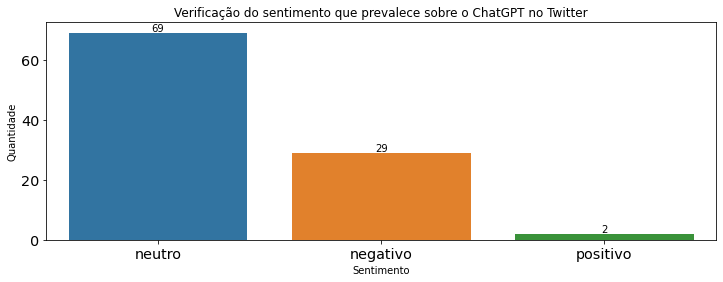

In [36]:
# Verificação das frequências dos sentimentos   (apply_lemmatize_text + remove_stop_word)
# Plot
ax = sns.countplot(data = df_pandas, x = 'sentiment', label = 'Count')

# Value counts
for label in ax.containers:
    ax.bar_label(label)
plt.title('Verificação do sentimento que prevalece sobre o ChatGPT no Twitter',fontsize=12)
plt.xlabel('Sentimento',fontsize=10) 
plt.ylabel('Quantidade',fontsize=10)
plt.show()

## <font color='red'>5 - Conclusão</font>

O objetivo deste trabalho foi identificar o sentimento das pessoas que predomina sobre o ChatGPT com o auxílio de processamento de linguagem de dados textuais extraídas de mensagens do Twitter. Nota-se que o sentimento netro possui maior número de classes, seguidas de negativo e positivo.

A análise de sentimento aplicada atendeu bem a proposta deste trabalho. Outras estratégias de pré-processamento de dados foram testadas, como a "Cleaning Special Characters", "Removal of Emojis", "Stemming" e "Vetorizador" [7]. Porém, os métodos que obtiveram melhores resultados foram os "Stop Word Removal" e a "Text Lemmatization" [7]. Também foi testado a possibilidade de não utilizar pré-processamento de dados, onde não foi obtido resultados melhores.

Para fins de trabalhos futuros, têm-se as seguintes considerações:

* A proposta deste trabalho é válida para mensagens de textos no idioma em inglês. É interessante aplicar a análise de sentimentos para incluir outros idiomas. Para isso, deve-se pesquisar por outras bibliotecas de processamento de linguagem de dados textuais [5].

* Ampliar a proposta para outras redes sociais e páginas da Internet para análise conjunta.

* Coletar maior volumetria de dados para análise;

* Testar o processo de análise de sentimentos com outros métodos de pré-processamento de dados;

* Experimentar outros métodos de aprendizados supervisionados para processamento de linguagem de dados textuais, como Pattern, spaCy, Naive Bayes e Redes Neurais. Também é válido testar com métodos de aprendizados não supervisionados, como NLTK (Natural Language Toolkit) e Orientação Semântica [6].

* Realizar estatísticas de acertos e erros oriundo da análise de sentimento para fins de conhecer a eficiência da biblioteca utilizada no processo de classificação das mensagens de texto.

## <font color='red'>6 - Referências bibliográficas</font>

[1]  Análise de sentimentos – Aprenda de uma vez por todas como funciona utilizando dados do Twitter. Disponível em: https://imasters.com.br/desenvolvimento/analise-de-sentimentos-aprenda-de-uma-vez-por-todas-como-funciona-utilizando-dados-do-twitter. Acesso em junho de 2023.


[2]  O que é ChatGPT e como acessar a inteligência artificial em português. Disponível em: https://olhardigital.com.br/2023/01/13/dicas-e-tutoriais/o-que-e-chatgpt-e-como-acessar-a-inteligencia-artificial-em-portugues/#h-o-que-e-o-chatgpt. Acesso em junho de 2023.


[3]  O que é inteligência artificial?. Disponível em: https://tecnoblog.net/responde/o-que-e-inteligencia-artificial/. Acesso em junho de 2023.


[4]  Afinal, para que serve o Twitter? Descubra agora como usar essa rede social. Disponível em: https://rockcontent.com/br/blog/para-que-serve-o-twitter/. Acesso em junho de 2023.


[5]  TextBlob - uma alternativa para o Processamento de Linguagem Natural. Disponível em: https://www.alura.com.br/artigos/textblob-alternativa-para-processamento-linguagem-natural?gclid=EAIaIQobChMItMqG46Ts_wIVdi3UAR2_bwcNEAAYASAAEgL85fD_BwE. Acesso em junho de 2023.


[6]  Análise de Sentimento com aprendizado supervisionado e não supervisionado. Disponível em: https://medium.com/neuronio-br/an%C3%A1lise-de-sentimento-com-aprendizado-supervisionado-e-n%C3%A3o-supervisionado-d885bd7ae620. Acesso em junho de 2023.


[7]  PLN – Processamento de Linguagem Natural para Iniciantes. Disponível em: https://www.insightlab.ufc.br/pln-processamento-de-linguagem-natural-para-iniciantes. Acesso em junho de 2023.